In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q pyspark==3.1.2 spark-nlp
# !pip install demoji
# !pip install nlpaug
# !pip install transformers
# import nlpaug.augmenter.word as naw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.7/471.7 KB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 23.1 MB/s eta 0:00:00


In [ ]:
import re
import os
import nltk
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from textblob import TextBlob
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from sparknlp.annotator import *
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand
from sparknlp.pretrained import PretrainedPipeline
from sklearn.metrics import classification_report, accuracy_score
np.random.seed(42)
spark = sparknlp.start(gpu = True)
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/content/augumented2.csv')
# df.drop('index',axis=1,inplace=True)
df.sample(20)


,tweet_text,cyberbullying_type
32623,when my daughter was bullied and jumped after ...,age
36403,i look better than the girl s that bullied me ...,age
28096,omg watching freebsd committers just rail at g...,other_cyberbullying
42217,while the suns photons dont penetrate past 200...,ethnicity
26441,now i am unreasonable heh okay in sj terms tha...,other_cyberbullying
28738,stupid idiot rr does not deserve to end career...,other_cyberbullying
53710,am so not looking forward to going back to school,not_cyberbullying
50157,thank you for that i am,not_cyberbullying
12964,just to clear things up i do not skip female c...,gender
36346,i watch my little girl live her life after bul...,age


In [ ]:
not_cyberbullying = df[df['cyberbullying_type']=='not_cyberbullying'].sample(9000)
cyberbullying = df[df['cyberbullying_type']!='not_cyberbullying']
df = pd.concat([not_cyberbullying,cyberbullying],axis =0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48140 entries, 52786 to 56658
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          48140 non-null  object
 1   cyberbullying_type  48140 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
df['cyberbullying_type'].value_counts()

not_cyberbullying      9000
religion               7950
age                    7927
other_cyberbullying    7873
ethnicity              7823
gender                 7567
Name: cyberbullying_type, dtype: int64

In [ ]:
print('Before - ', df.duplicated().sum())
df.drop_duplicates(subset='tweet_text',inplace=True)
print('After - ', df.duplicated().sum())

Before -  1
After -  0


In [ ]:
def textClean(text):
  nonAscii = re.sub('[^\x00-\x7F]',' ', text)
  # nonpunctuation = re.sub(r'[^\w\s]', '', nonAscii) #removing punctuations
  # nonHttp = re.sub("http\S+", ' ', non_mention)
  # nonCom = re.sub(r'\ [A-Za-z]*\.com', ' ', nonHttp)
  # nonAlphaNumeric = re.sub("[^A-Za-z0-9\s]", " ", nonCom)
  # nonExtraSpaces = re.sub('\s{2,}', " ", nonAscii)
  return nonAscii

In [ ]:
df['cleaned_text'] = df['tweet_text'].apply(textClean)
df.sample(20)

,tweet_text,cyberbullying_type,cleaned_text
114,dr tell of escape from,not_cyberbullying,dr tell of escape from
18177,i do not see you doing anything for muslims or...,religion,i do not see you doing anything for muslims or...
28325,sure ama is here,other_cyberbullying,sure ama is here
15718,i like how you jump past misogyny homophobia f...,religion,i like how you jump past misogyny homophobia f...
55008,yeah i remembered reading about that i think s...,not_cyberbullying,yeah i remembered reading about that i think s...
11815,lmao we called her out on her gay rape jokes n...,gender,lmao we called her out on her gay rape jokes n...
44559,is a carnivore when you stay up all night slee...,ethnicity,is a carnivore when you stay up all night slee...
16620,noble peace prize winner over equal rights for...,religion,noble peace prize winner over equal rights for...
30539,you bullied and mocked a young girl trying to ...,age,you bullied and mocked a young girl trying to ...
24559,kyou chan is a bully d,other_cyberbullying,kyou chan is a bully d


In [ ]:
spark_df = spark.createDataFrame(df)
spark_df.show(1,False)

+---------------------------------------------------------------------------------------------------------+------------------+---------------------------------------------------------------------------------------------------------+
|tweet_text                                                                                               |cyberbullying_type|cleaned_text                                                                                             |
+---------------------------------------------------------------------------------------------------------+------------------+---------------------------------------------------------------------------------------------------------+
|a lot of people say they cannot run because it is too boring but i can daydream for hours about all sorts|not_cyberbullying |a lot of people say they cannot run because it is too boring but i can daydream for hours about all sorts|
+-------------------------------------------------------------------

In [ ]:
print('Duplicates', spark_df.toPandas().duplicated().sum())
spark_df.toPandas()['cyberbullying_type'].value_counts()

Duplicates 0


not_cyberbullying      9000
religion               7950
age                    7927
other_cyberbullying    7872
ethnicity              7823
gender                 7567
Name: cyberbullying_type, dtype: int64

In [ ]:
train, test = spark_df.randomSplit([0.90,0.10],43)
# train.toPandas()['cyberbullying_type'].value_counts()
# test.toPandas()['cyberbullying_type'].value_counts()

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("tweet_text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained(name="tfhub_use_lg", lang="en")\
 .setInputCols("document")\
 .setOutputCol("sentence_embeddings")\
 .setDimension(768)

# classifierdl = ClassifierDLModel.load('/content/drive/MyDrive/NLP/newdatamodel1')\
# .setInputCols(['sentence_embeddings'])\
# .setOutputCol("class")

# Download version
classifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("cyberbullying_type")\
  .setBatchSize(16)\
  .setMaxEpochs(42)\
  .setDropout(0.4) \
  .setEnableOutputLogs(True)\
  .setLr(4e-3)
use_clf_pipeline = Pipeline(
    stages = [documentAssembler,
        use,
        classifierdl])

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


In [ ]:
!rm -r /root/annotator_logs

rm: cannot remove '/root/annotator_logs': No such file or directory


In [ ]:
%%time
pipelineModel = use_clf_pipeline.fit(train)

CPU times: user 4.86 s, sys: 432 ms, total: 5.29 s
Wall time: 14min 13s


In [ ]:
import os
log_files = os.listdir("/root/annotator_logs")
log_files

['ClassifierDLApproach_d57f854b34fd.log']

In [ ]:
pipelineModel.stages

[DocumentAssembler_6e7c4bbbb6f0,
 UNIVERSAL_SENTENCE_ENCODER_5e0d8b922c74,
 ClassifierDLModel_f932de1f07a0]

In [ ]:
# pipelineModel.stages[2].write().overwrite().save("/content/drive/MyDrive/NLP/rishabmodels/model_85_perfect")

In [ ]:
# pipelineModel.save('/content/drive/MyDrive/NLP/rishabmodels/pipelineModel/auc_85_perfect')

In [ ]:
!cat ~/annotator_logs/{classifierdl.uid}.log

Training started - epochs: 42 - learning_rate: 0.004 - batch_size: 16 - training_examples: 43400 - classes: 6
Epoch 0/42 - 7.04s - loss: 3364.4546 - acc: 0.7922428 - batches: 2713
Epoch 1/42 - 5.51s - loss: 3261.3276 - acc: 0.83112097 - batches: 2713
Epoch 2/42 - 5.08s - loss: 3226.8735 - acc: 0.84563977 - batches: 2713
Epoch 3/42 - 6.17s - loss: 3198.0483 - acc: 0.856356 - batches: 2713
Epoch 4/42 - 4.73s - loss: 3179.045 - acc: 0.8640763 - batches: 2713
Epoch 5/42 - 5.09s - loss: 3159.7505 - acc: 0.8705522 - batches: 2713
Epoch 6/42 - 5.89s - loss: 3149.8582 - acc: 0.8758066 - batches: 2713
Epoch 7/42 - 4.79s - loss: 3143.8213 - acc: 0.87986267 - batches: 2713
Epoch 8/42 - 5.42s - loss: 3135.4004 - acc: 0.88364214 - batches: 2713
Epoch 9/42 - 5.59s - loss: 3124.998 - acc: 0.8870529 - batches: 2713
Epoch 10/42 - 4.77s - loss: 3120.2896 - acc: 0.88944966 - batches: 2713
Epoch 11/42 - 6.21s - loss: 3115.3665 - acc: 0.89170814 - batches: 2713
Epoch 12/42 - 4.90s - loss: 3111.3523 - acc: 

In [ ]:
import os
log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Training started - epochs: 42 - learning_rate: 0.004 - batch_size: 16 - training_examples: 43400 - classes: 6
Epoch 0/42 - 7.04s - loss: 3364.4546 - acc: 0.7922428 - batches: 2713
Epoch 1/42 - 5.51s - loss: 3261.3276 - acc: 0.83112097 - batches: 2713
Epoch 2/42 - 5.08s - loss: 3226.8735 - acc: 0.84563977 - batches: 2713
Epoch 3/42 - 6.17s - loss: 3198.0483 - acc: 0.856356 - batches: 2713
Epoch 4/42 - 4.73s - loss: 3179.045 - acc: 0.8640763 - batches: 2713
Epoch 5/42 - 5.09s - loss: 3159.7505 - acc: 0.8705522 - batches: 2713
Epoch 6/42 - 5.89s - loss: 3149.8582 - acc: 0.8758066 - batches: 2713
Epoch 7/42 - 4.79s - loss: 3143.8213 - acc: 0.87986267 - batches: 2713
Epoch 8/42 - 5.42s - loss: 3135.4004 - acc: 0.88364214 - batches: 2713
Epoch 9/42 - 5.59s - loss: 3124.998 - acc: 0.8870529 - batches: 2713
Epoch 10/42 - 4.77s - loss: 3120.2896 - acc: 0.88944966 - batches: 2713
Epoch 11/42 - 6.21s - loss: 3115.3665 - acc: 0.89170814 - batches: 2713
Epoch 12/42 - 4.90s - loss: 3111.3523 - acc: 

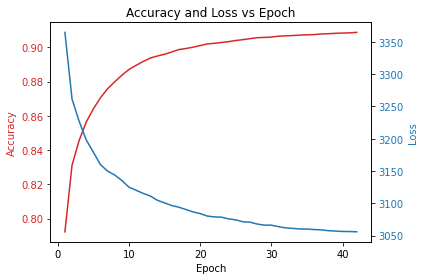

In [ ]:
import matplotlib.pyplot as plt

# Read the log file
import os
log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    lines = log_file.readlines()


# Extract the accuracy and loss values for each epoch
accuracies = []
losses = []
for line in lines:
    if 'acc:' in line:
        accuracy = float(line.split('acc:')[1].split()[0])
        accuracies.append(accuracy)
    if 'loss:' in line:
        loss = float(line.split('loss:')[1].split()[0])
        losses.append(loss)

# Plot the accuracy and loss vs epoch graph
epochs = range(1, len(accuracies) + 1)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(epochs, accuracies, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(epochs, losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy and Loss vs Epoch')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
result = pipelineModel.transform(test)

In [ ]:
preds_df = result.select('cyberbullying_type','tweet_text',"class.result").toPandas()

In [ ]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

In [ ]:
print(accuracy_score(preds_df['cyberbullying_type'], preds_df['result']))

0.856509812196666


In [ ]:
print(classification_report(preds_df['cyberbullying_type'], preds_df['result']))

                     precision    recall  f1-score   support

                age       0.95      0.97      0.96       800
          ethnicity       0.94      0.95      0.95       774
             gender       0.91      0.83      0.87       744
  not_cyberbullying       0.73      0.73      0.73       850
other_cyberbullying       0.68      0.70      0.69       781
           religion       0.94      0.96      0.95       790

           accuracy                           0.86      4739
          macro avg       0.86      0.86      0.86      4739
       weighted avg       0.86      0.86      0.86      4739



In [ ]:
df = pd.read_csv('/content/tweet.csv')
df['tweet_text'] = df['tweet_text'].apply(textClean)
new_data = spark.createDataFrame(df)
# predictions = pipelineModel.transform(new_data)
# pred =predictions.select('tweet_text',"class.result")
# dir(PretrainedPipeline)
pipeline  = PretrainedPipeline.from_disk('/content/drive/MyDrive/NLP/Models/pipelineModel/newdatamodel')
preds = pipeline.transform(new_data)
pred =preds.select('tweet_text',"class.result")
validated_paras = pred.toPandas()

In [ ]:
validated_paras

,tweet_text,result
0,"@KariLake @JoeBiden Go away, loser",[other_cyberbullying]
1,"@ACTBrigitte Joe Biden was, we were just distr...",[not_cyberbullying]
2,"@simonateba @WhiteHouse @JoeBiden Humm, yet he...",[not_cyberbullying]
3,Service fees are made up. Gotta pay niggas to ...,[ethnicity]
4,"@JoeBiden Joe, please deeply look at yourself....",[other_cyberbullying]
5,@FirstCupCoffee2 @JoeBiden In what way Maria?,[not_cyberbullying]
6,@AvgJoe444 @KariLake @JoeBiden Trump certainly...,[not_cyberbullying]
7,@KamalaHarris @JoeBiden You misspelled Ukrain...,[not_cyberbullying]
8,@RaheemKassam Ed.D. Wrote a thesis about junio...,[age]
9,"@POTUS Is Joe Biden, the president of Ukraine?...",[ethnicity]


In [ ]:
validated_paras.to_csv('/content/joe_biden_tweets.csv',index=False)

## Loading Saved Pipeline

In [ ]:
tweets = ["You're too old to be playing video games, why don't you grow up and act your age? #ageism #cyberbullying",
          "Why don't you just retire and leave the workforce to people who actually know what they're doing? #ageist #useless",
          "Stop trying to act like a teenager, you're clearly not cool anymore #oldie #loser",
          "Women belong in the kitchen, not in positions of power #sexist #misogynist",
          "Men are so stupid, they can't even handle basic tasks #stereotyping #sexism",
          "Transgender people aren't real, they're just confused and attention-seeking #transphobia #ignorance",
          "I don't want to sit next to you on the bus, you might have coronavirus because you're Asian #racist #ignorance",
          "You're only successful because of affirmative action, not because of your own merit #racist #biased",
          "I'm not going to hire someone with a name like that, they're probably not even from here.#discrimination #prejudice",
          "Your religion is a cult and brainwashes people. #hate #religiouscriticism",
          "Jews control the world, they're the reason for all our problems #anti-semitism #conspiracytheory",
          "Christians are so stupid, they believe in a fairy tale #religiousintolerance #ignorance",
          "You're such a loser, you can't even get a single like on your posts #onlinebullying #harassment",
          "Nobody likes you, you should just kill yourself and do everyone a favor #cyberbullying #abuse",
          "You're so ugly, no wonder nobody wants to be seen with you #bodyshaming #onlinehate",
          "I just finished a great workout at the gym, feeling energized and ready for the day! #fitness #health",
          "The sunset over the ocean is so beautiful, I feel grateful to be alive to see it #nature #gratitude",
          "I'm so excited for the new movie coming out this weekend, can't wait to see it with my friends! #entertainment #fun"]

df = pd.DataFrame(tweets)
df.columns = ['tweet_text']
sparkdf = spark.createDataFrame(df)
sparkdf.show()

+--------------------+
|          tweet_text|
+--------------------+
|You're too old to...|
|Why don't you jus...|
|Stop trying to ac...|
|Women belong in t...|
|Men are so stupid...|
|Transgender peopl...|
|I don't want to s...|
|You're only succe...|
|I'm not going to ...|
|Your religion is ...|
|Jews control the ...|
|Christians are so...|
|You're such a los...|
|Nobody likes you,...|
|You're so ugly, n...|
|I just finished a...|
|The sunset over t...|
|I'm so excited fo...|
+--------------------+



In [ ]:
# predictions = pipelineModel.transform(sparkdf)
# pred =predictions.select('tweet_text',"class.result")
# pred.toPandas()

In [ ]:
pipeline  = PretrainedPipeline.from_disk('/content/drive/MyDrive/NLP/Models/pipelineModel/auc_88.53')

In [ ]:
# dir(PretrainedPipeline)
preds = pipeline.transform(sparkdf)
pred =preds.select('tweet_text',"class.result")
pred.toPandas()

,tweet_text,result
0,"You're too old to be playing video games, why ...",[age]
1,Why don't you just retire and leave the workfo...,[ethnicity]
2,"Stop trying to act like a teenager, you're cle...",[age]
3,"Women belong in the kitchen, not in positions ...",[gender]
4,"Men are so stupid, they can't even handle basi...",[gender]
5,"Transgender people aren't real, they're just c...",[gender]
6,"I don't want to sit next to you on the bus, yo...",[ethnicity]
7,You're only successful because of affirmative ...,[ethnicity]
8,I'm not going to hire someone with a name like...,[other_cyberbullying]
9,Your religion is a cult and brainwashes people...,[religion]
